# Chapter 5
## Detection Using Cross Correlation With Whistler Kernel

In [1]:
import os, sys
import numpy as np
from math import floor
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tqdm import tqdm
import h5py
from scipy import signal
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from sample import Sample
from dataset import Dataset
from database import Database
from cfar_detector import CFARDetector
from detector_generator import DetectorGenerator

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
site = 'marion'
database = Database(dataset_loc, database_loc, site)

linewidth = 2
font_title = 32
font_legend = 20
font_label = 24
font_ticks = 18
font = [font_title, font_legend, font_label, font_ticks, linewidth] # [None]*5

## **5.3 Spectrogram**

**Cropped spectrogram**

In [51]:
detector_gen = DetectorGenerator(dataset_loc, database_loc, result_loc, site)
trans_set = [None,'zscore','detrend','detrend']
trans_params_set = [None,None,'constant','linear']
results = []

scale_mean,scale_std,scale = 1.448, 0.268, 4

for t,t_params in zip(trans_set, trans_params_set):
    transforms=['slice', t, 'scale']
    transforms_params=[[1.5,9.5],[t_params], [0,1]]
    detector_gen.generate_correlation(transforms, transforms_params, kernel_type='sim', train=True, save=True, n=None)
    data = detector_gen.load_generated_correlation(transforms, transforms_params, kernel_type='sim', train=True)
    target_corr, noise_corr = detector_gen.load_generated_correlation_interference(transforms, transforms_params, kernel_type='sim', train=True)
    target_corr = 10*np.log10(target_corr**2)
    noise_corr = 10*np.log10(noise_corr**2)
    results.append([target_corr.mean(), target_corr.std(), noise_corr.mean(), noise_corr.std(),])
results = np.array(results)

100%|██████████| 1471/1471 [00:09<00:00, 152.23it/s]


In [52]:
print(results)
print(results[:,0]-results[:,2])

[[59.0271456   1.06182761 58.22767735  0.80597991]
 [60.11276818  0.93498814 59.36192698  0.59010404]
 [60.1594046   1.06774109 59.45402145  0.87694196]
 [60.46804464  0.99152717 59.87651451  0.82827002]]
[0.79946825 0.7508412  0.70538316 0.59153012]


2013-06-04UT17:08:17.98260594.marion.vr2


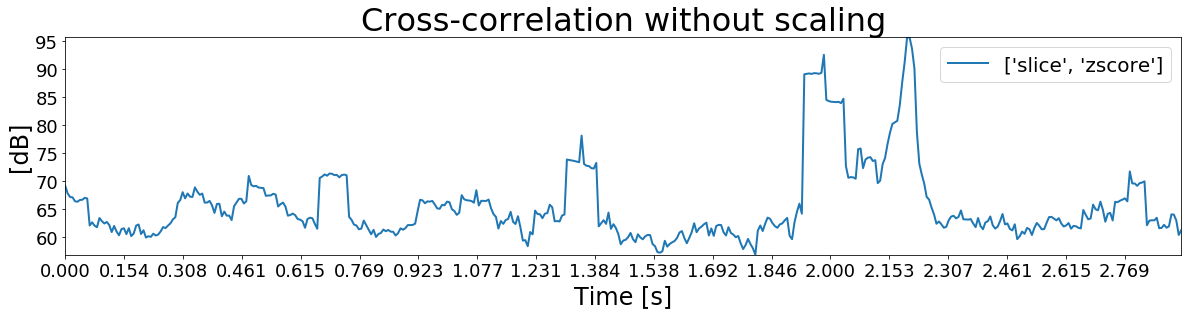

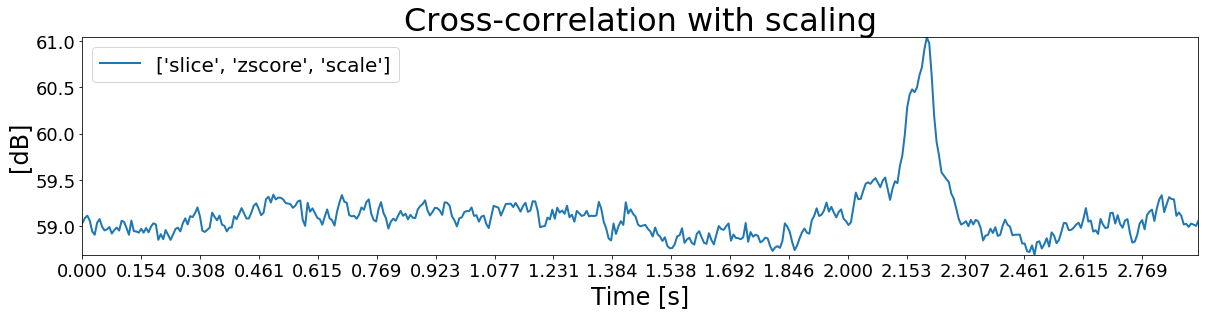

In [2]:
file = np.random.choice(database.get_train(),1)[0]
# file = '2013-08-14UT21:12:15.59651906.marion.vr2'
# file = '2013-07-20UT14:38:29.20291914.marion.vr2'
file = '2013-06-04UT17:08:17.98260594.marion.vr2'
print(file)
sample = CFARDetector(dataset_loc, site, file)
freq_size = 4
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size)
figsize=sample.get_figsize()
kernel = sample.load_kernel('sim', [0.35,80,1])
sample.plot_corr_output([['slice','zscore']], [[[1.5,9.5],[None]]], [], [], kernel=kernel, thresholds=[],
                        detection=False, mean=False, figsize=(figsize[0],4), title='Cross-correlation without scaling',font=font)
sample.plot_corr_output([['slice','zscore','scale']], [[[1.5,9.5],[None],[0,1]]], [], [], kernel=kernel, thresholds=[],
                        detection=False, mean=False, figsize=(figsize[0],4), title='Cross-correlation with scaling',font=font)

## **5.4 Cross-Correlation**

2013-04-22UT01:28:03.48279656.marion.vr2


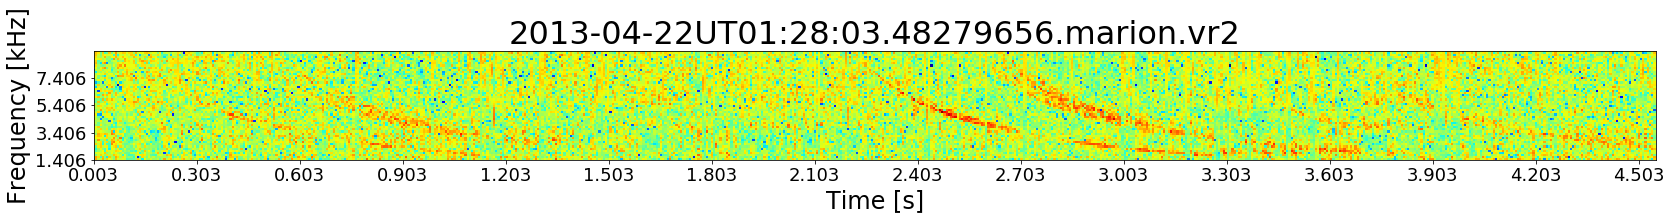

410 3.5622966292134834
(52, 156)


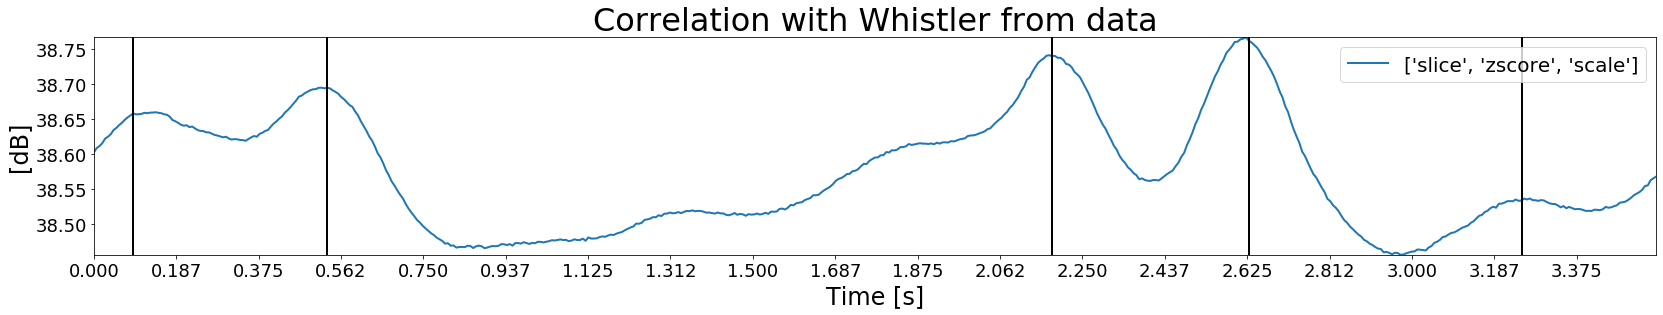

345 3.3832224719101127
(52, 184)


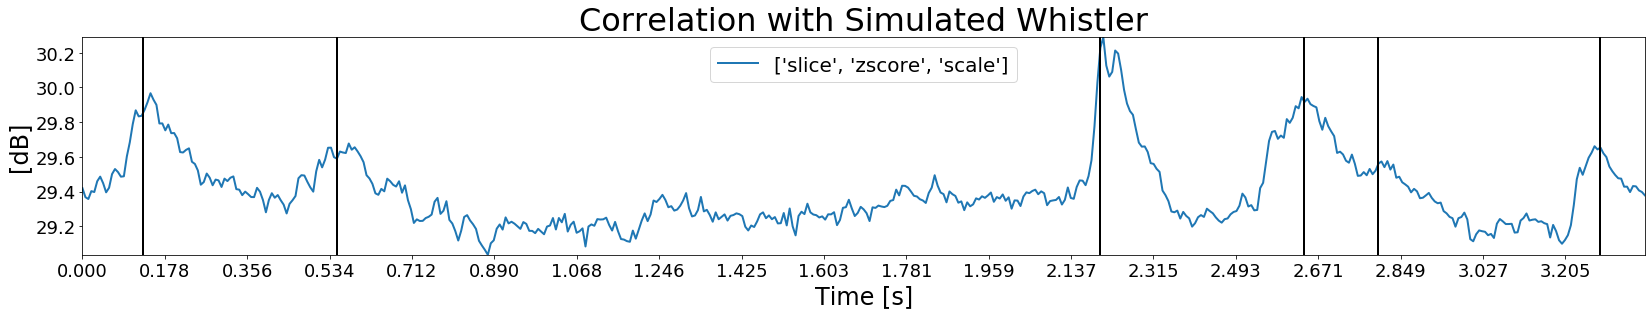

In [16]:
file = '2013-04-22UT01:28:03.48279656.marion.vr2'
print(file)
sample = CFARDetector(dataset_loc, site, file)
transforms, transforms_params = ['slice','zscore','scale'],[[1.5,9.5],[None],[0,1]]
cfar, cfar_params = 'ca_cfar', [15,10,1e-3]
sample.spectrogram_with_axis(log10=True)
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size/2)
sample.apply_transform(transforms, transforms_params)
figsize = sample.get_figsize()

sample.spectrogram_plot(figsize=sample.get_figsize(),xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                           xaxis=True, yaxis=True,ticks=[0.3,2],title=sample.get_file(), cmap='jet', cmap_show=False, font=font)

kernel = sample.load_kernel('mean', [os.path.join(database_loc, site, 'kernels', 'kernel_data.h5')])
kernel = ((kernel-kernel.min())/(kernel.max()-kernel.min()))
corr = signal.correlate(10**sample.get_spectrogram(), kernel, mode='valid')[0]
print(np.argmax(corr), (len(corr))*sample.get_time_res())
print(kernel.shape)
sample.plot_corr_output([transforms], [transforms_params], [cfar], [cfar_params], kernel=kernel, thresholds=[], detection=False, 
                        figsize=(figsize[0],4),title='Correlation with Whistler from data', vlines=[0.09,0.53,2.18,2.63, 3.25],font=font, squared=False)


kernel = sample.load_kernel('sim', [0.35,80,1])
corr = signal.correlate(10**sample.get_spectrogram(), kernel, mode='valid')[0]
print(np.argmax(corr), (len(corr))*sample.get_time_res())
print(kernel.shape)
sample.plot_corr_output([transforms], [transforms_params], [cfar], [cfar_params], kernel=kernel, thresholds=[], detection=False, 
                        figsize=(figsize[0],4),title='Correlation with Simulated Whistler', vlines=[0.13,0.55,2.2,2.64,2.8,3.28],font=font, squared=False)

## **5.5 Detector**

### 5.5.1 A need for an adaptive threshold

In [4]:
detector_gen = DetectorGenerator(dataset_loc, database_loc, result_loc, site)
transforms=['slice','zscore','scale']
transforms_params=[[1.5,9.5],[None],[0,1]]
# detector_gen.generate_correlation(transforms, transforms_params, kernel_type='sim', train=True, save=True, n=None)
data = detector_gen.load_generated_correlation(transforms, transforms_params, kernel_type='sim', train=True)
target_data, noise_data = detector_gen.load_generated_correlation_interference(transforms, transforms_params, kernel_type='sim', train=True)

100%|██████████| 1471/1471 [00:15<00:00, 40.08it/s]


Target+Interference: min=712.04,max=1528.92
Interference: min=690.76,max=1492.22
Target+Interference: mean=30.06, std=0.47
Interference: mean=29.68, std=0.30
Target-Interference = 0.38


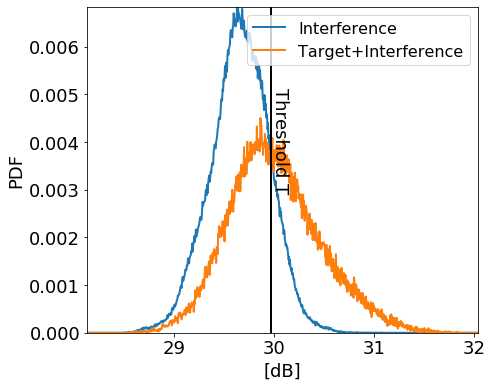

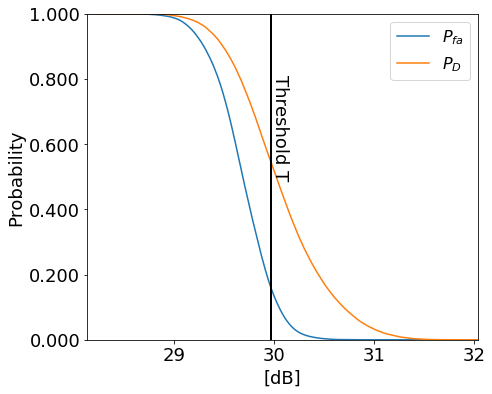

T = 29.97
Pfa=1.58e-01, Pd= 5.44e-01
X_dB=2.85
[993, 1012, 1087, 1117]
[2.85448694 3.91862999 7.1549261  8.04398755]


In [5]:
target_mean, target_std = 10*np.log10(target_data).mean(), 10*np.log10(target_data).std()
noise_mean, noise_std = 10*np.log10(noise_data).mean(), 10*np.log10(noise_data).std()
print('Target+Interference: min=%.2f,max=%.2f'%(target_data.min(),target_data.max()))
print('Interference: min=%.2f,max=%.2f'%(noise_data.min(),noise_data.max()))
print('Target+Interference: mean=%.2f, std=%.2f'%(target_mean,target_std))
print('Interference: mean=%.2f, std=%.2f'%(noise_mean,noise_std))
print('Target-Interference = %.2f'%(target_mean-noise_mean))

xmin, xmax = 650,1600
bins = np.linspace(xmin,xmax,(xmax-xmin)+1)
noise_pdf, nbins = np.histogram(noise_data, bins=bins, density=True)
target_pdf, tbins = np.histogram(target_data, bins=bins, density=True)
Pfa = np.array([noise_pdf[int(b)-xmin:].sum() for b in nbins[:-1]])
Pd = np.array([target_pdf[int(b)-xmin:].sum() for b in tbins[:-1]])
# T = int(xmin+np.argmax(target_pdf)+2*target_std)
T = xmin + np.argmax(Pd-Pfa)
fig, pdf_ax = plt.subplots(1,1,figsize=(7,6))
pdf_ax.plot(10*np.log10(bins[:-1]),noise_pdf, linewidth=font[-1])
pdf_ax.plot(10*np.log10(bins[:-1]),target_pdf, linewidth=font[-1])
pdf_ax.legend(['Interference', 'Target+Interference'], fontsize=font[3]-2)
pdf_ax.axvline(10*np.log10(T),color='black', linewidth=font[-1])
pdf_ax.text(10*np.log10(T), 0.003,'Threshold T', rotation=270, fontsize=font[3])
pdf_ax.autoscale(tight=True)
pdf_ax.set_xlabel('[dB]', fontsize=font[3])
pdf_ax.set_ylabel('PDF', fontsize=font[3])
pdf_ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
pdf_ax.tick_params(labelsize=font[3])

fig, pfa_ax = plt.subplots(1,1,figsize=(7,6))
pfa_ax.plot(10*np.log10(bins[:-1]),Pfa)
pfa_ax.plot(10*np.log10(bins[:-1]),Pd)
pfa_ax.legend(['$P_{fa}$', '$P_D$'], fontsize=font[3]-2)
pfa_ax.axvline(10*np.log10(T),color='black', linewidth=font[-1])
pfa_ax.text(10*np.log10(T), 0.5,'Threshold T', rotation=270,fontsize=font[3])
pfa_ax.autoscale(tight=True)
pfa_ax.set_xlabel('[dB]', fontsize=font[3])
pfa_ax.set_ylabel('Probability', fontsize=font[3])
pfa_ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
pfa_ax.tick_params(labelsize=font[3])

plt.show()

T = int(T)
pfa = noise_pdf[T-xmin:].sum()
pd = target_pdf[T-xmin:].sum()
print('T = %.2f'% (10*np.log10(T)))
print('Pfa=%.2e, Pd= %.2e'%(pfa, pd))

N=10
X_dB = 10*np.log10(2*N*(pfa**(-1/(2*N))-1))
print('X_dB=%.2f'%X_dB)
Ts = [T, xmin+int(np.argwhere(Pfa<=1e-1)[0]), xmin+int(np.argwhere(Pfa<=1e-2)[0]), xmin+int(np.argwhere(Pfa<=4e-3)[0])]
Pfas = np.array([ noise_pdf[T-xmin:].sum() for T in Ts])
Xs = 10*np.log10(2*N*(Pfas**(-1/(2*N))-1))
print(Ts)
print(Xs)

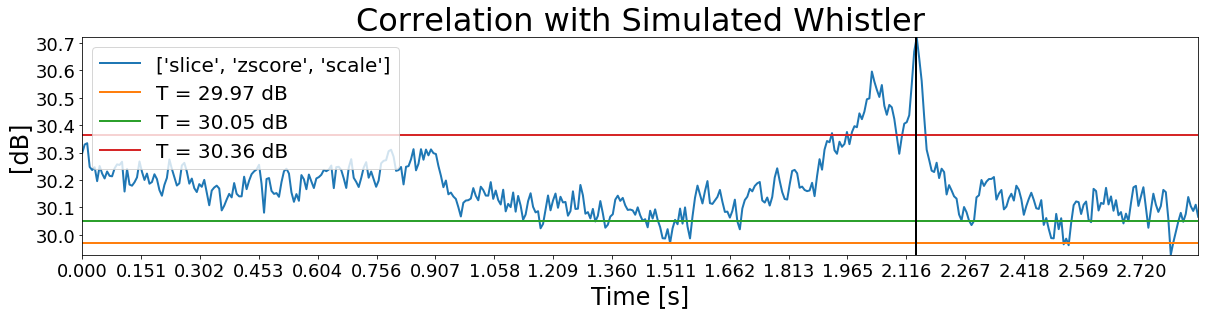

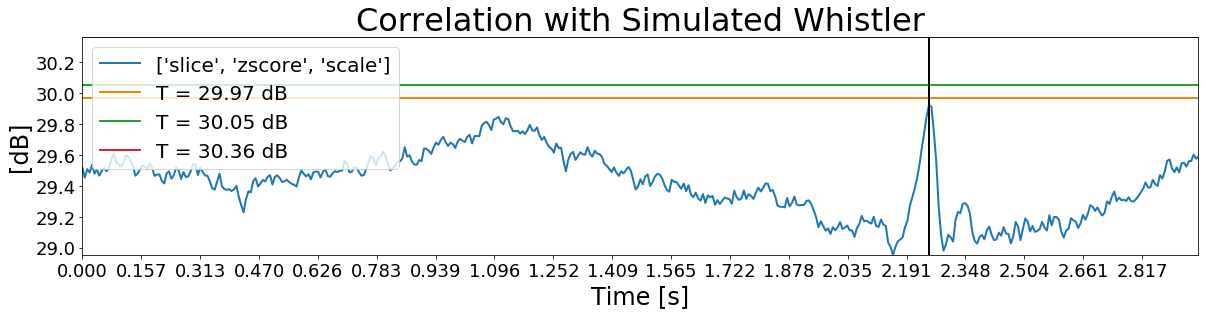

In [6]:
T = 10**(29.97/10)
thresholds = 10*np.log10(np.array([T, xmin+int(np.argwhere(Pfa<=1e-1)[0]), xmin+int(np.argwhere(Pfa<=1e-2)[0])]))
transforms, transforms_params = ['slice','zscore','scale'],[[1.5,9.5],[None],[0,1]]
cfar, cfar_params = 'ca_cfar', [15,10,1e-3]
# reason for adaptive threshold
files = ['2013-07-23UT17:43:48.20451906.marion.vr2', '2013-04-22UT01:28:03.48279656.marion.vr2',
         '2013-07-05UT19:09:09.53571914.marion.vr2','2013-07-02UT14:43:13.05571914.marion.vr2','2013-01-27UT00:41:13.39427602.marion.vr2']
lines = [[2.2,2.43, 2.95],[0.15,0.56,2.21,2.64,2.81],[2.25,2.36,2.5],[2.14],[2.25]]
ix = -2
file, line = files[ix], lines[ix]
sample = CFARDetector(dataset_loc, site, file)
sample.spectrogram_with_axis(log10=True)
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size/2)
figsize=sample.get_figsize()
kernel = sample.load_kernel('sim', [0.35,80,1])
sample.plot_corr_output([transforms], [transforms_params], [cfar], [cfar_params], kernel=kernel, thresholds=thresholds, detection=False, 
                        figsize=(figsize[0],4),title='Correlation with Simulated Whistler', vlines=line,font=font,squared=False,legend_loc='upper left')
ix = -1
file, line = files[ix], lines[ix]
sample = CFARDetector(dataset_loc, site, file)
sample.spectrogram_with_axis(log10=True)
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size/2)
figsize=sample.get_figsize()
kernel = sample.load_kernel('sim', [0.35,80,1])
sample.plot_corr_output([transforms], [transforms_params], [cfar], [cfar_params], kernel=kernel, thresholds=thresholds, detection=False, 
                        figsize=(figsize[0],4),title='Correlation with Simulated Whistler', vlines=line,font=font,squared=False,legend_loc='upper left')

### 5.5.2 CFAR Detectors

#### CFAR Window

2013-07-23UT17:43:48.20451906.marion.vr2 [[2.2, 2.43, 2.95], [0.15, 0.56, 2.21, 2.64, 2.81], [2.25, 2.36, 2.5], [2.14], [2.25]] [2.2, 2.43, 2.95]
unit cell = 1, 6.40ms
Noise duration = 10, 63.95ms
Guard duration = 7, 44.77ms
Window duration = 35, 223.83ms
One sided Window duration = 17, 111.91ms


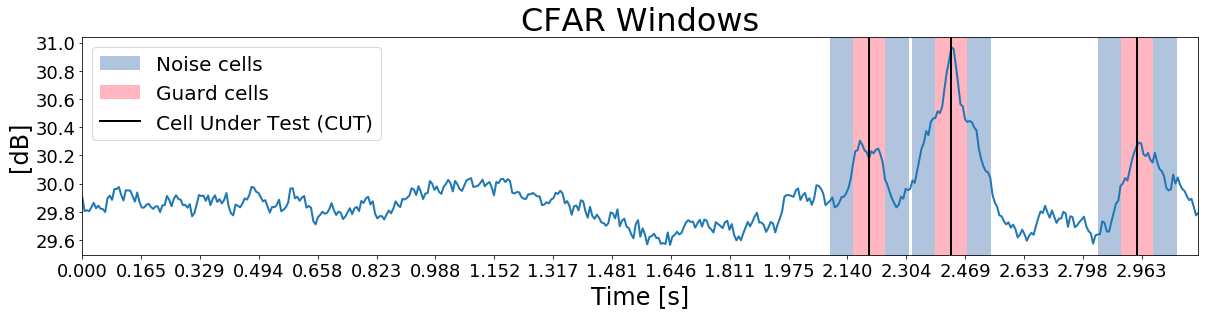

In [7]:
ix = 0
file, line = files[ix], lines[ix]
print(file, lines, line)
transforms, transforms_params = ['slice','zscore', 'scale'],[[1.5,9.5],[None],[0,1]]
N,G = 10,7
cfar, cfar_params = 'ca_cfar', [N,G,pfa]

print('unit cell = %d, %.2fms'% (1,sample.get_time_res()*1e3))
print('Noise duration = %d, %.2fms'%(N,N*sample.get_time_res()*1e3))
print('Guard duration = %d, %.2fms'%(G,G*sample.get_time_res()*1e3))
print('Window duration = %d, %.2fms'%((1+2*N+2*G),(1+2*N+2*G)*sample.get_time_res()*1e3))
print('One sided Window duration = %d, %.2fms'%((N+G),(1+2*N+2*G)*sample.get_time_res()*1e3/2))

sample = CFARDetector(dataset_loc, site, file)
sample.spectrogram_with_axis(log10=True)
sample.apply_transform(transforms, transforms_params)

corr = signal.correlate(10**sample.get_spectrogram(), kernel, mode='valid')[0]
detect = sample.apply_cfar_detector(transforms, transforms_params, kernel, cfar, cfar_params)
x_axis = list(range(len(corr))*sample.get_time_res())

plt.figure(figsize=(figsize[0],4))
plt.plot(x_axis, 10*np.log10(corr), linewidth=font[-1])
y1,y2 = plt.gca().get_ylim()
for i in line:
    vlines = np.array([-G-N,-G,0,G,G+N])*sample.get_time_res()+i
    plt.fill_between(vlines[:2], y1=y1,y2=y2, color='lightsteelblue')
    plt.fill_between(vlines[1:3], y1=y1,y2=y2,color='lightpink')
    plt.axvline(vlines[2], color='black', linewidth=font[-1])
    plt.fill_between(vlines[2:4], y1=y1,y2=y2,color='lightpink')
    plt.fill_between(vlines[3:], y1=y1,y2=y2, color='lightsteelblue')  
plt.xticks(np.linspace(0,len(corr),20)*sample.get_time_res(), fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.autoscale(tight=True)
legend = [Patch(facecolor='lightsteelblue',label='Noise cells'),
          Patch(facecolor='lightpink',label='Guard cells'),
                  Line2D([0], [0], color='black', lw=2, label='Cell Under Test (CUT)')]
plt.legend(handles=legend,fontsize=font[1])
plt.xlabel('Time [s]',fontsize=font[2])
plt.ylabel('[dB]',fontsize=font[2])
plt.title('CFAR Windows',fontsize=font[0])
plt.show()

#### CFAR Pfa

In [8]:
target_power = 10*np.log10(target_data**2)
noise_power = 10*np.log10(noise_data**2)  
target_mean_power, target_std_power = target_power.mean(), target_power.std()
noise_mean_power, noise_std_power = noise_power.mean(), noise_power.std()
print('Target+Interference power: mean=%.2f, std=%.2f'%(target_mean_power, target_std_power))
print('Interference power: mean=%.2f, std=%.2f'%(noise_mean_power, noise_std_power))
print('Target-Interference power = %.2f'%(target_mean_power-noise_mean_power))

desiredX_dB = 0.5
theorical_pfa = (1/(1+((10**(desiredX_dB/10))/(2*N))))**(2*N)
ca = 2*N*((theorical_pfa**(-1/(2*N)))-1)
theorical_pd = (1+ca/(2*N*(1+desiredX_dB)))**(-2*N)
practical_T = xmin+np.argwhere(Pfa<=theorical_pfa)[0]
practical_pfa = noise_pdf[int(practical_T)-xmin:].sum()
practical_pd = target_pdf[int(practical_T)-xmin:].sum()
print('Desired X_dB=%.2f'%desiredX_dB)
print('Theoretical Pfa=%.2e'%theorical_pfa)
print('Theoretical Pd=%.2e'%theorical_pd)
print('Associate threshold T=%.2f'%(10*np.log10(practical_T)))
print('Practical Pd=%.2e'%practical_pd)

Target+Interference power: mean=60.11, std=0.93
Interference power: mean=59.36, std=0.59
Target-Interference power = 0.75
Desired X_dB=0.50
Theoretical Pfa=3.36e-01
Theoretical Pd=4.80e-01
Associate threshold T=29.81
Practical Pd=6.82e-01


unit cell = 1 cell, 6.40ms
Noise duration = 10 cell[s], 63.95ms
Guard duration = 7 cell[s], 44.77ms
Window duration = 35 cell[s], 223.83ms
One sided Window duration = 17 cell[s], 111.92ms


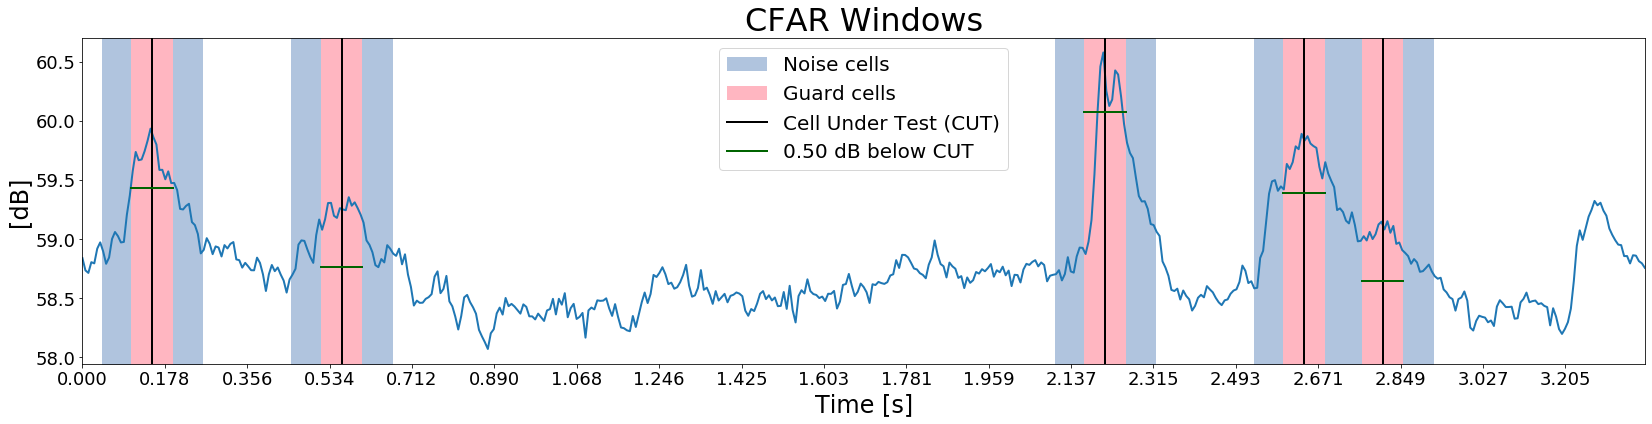

In [9]:
ix = 1
file, line = files[ix], lines[ix]
transforms, transforms_params = ['slice','zscore','scale'],[[1.5,9.5],[None],[0,1]]

print('unit cell = %d cell, %.2fms'% (1,sample.get_time_res()*1e3))
print('Noise duration = %d cell[s], %.2fms'%(N,N*sample.get_time_res()*1e3))
print('Guard duration = %d cell[s], %.2fms'%(G,G*sample.get_time_res()*1e3))
print('Window duration = %d cell[s], %.2fms'%((1+2*N+2*G),(1+2*N+2*G)*sample.get_time_res()*1e3))
print('One sided Window duration = %d cell[s], %.2fms'%((N+G),(1+2*N+2*G)*sample.get_time_res()*1e3/2))

sample = CFARDetector(dataset_loc, site, file)
sample.spectrogram_with_axis(log10=True)

freq_size = 4
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size/2)
sample.apply_transform(transforms, transforms_params)
figsize = sample.get_figsize()

corr = signal.correlate(10**sample.get_spectrogram(), kernel, mode='valid')[0]
corr = corr**2
x_axis = list(range(len(corr))*sample.get_time_res())

plt.figure(figsize=(figsize[0],6))
plt.plot(x_axis, 10*np.log10(corr), linewidth=font[-1])
y1,y2 = plt.gca().get_ylim()
for i in line:
    vlines = np.array([-G-N,-G,0,G,G+N])*sample.get_time_res()+i
    plt.fill_between(vlines[:2], y1=y1,y2=y2, color='lightsteelblue')
    plt.fill_between(vlines[1:3], y1=y1,y2=y2,color='lightpink')
    plt.axvline(vlines[2], color='black', linewidth=font[-1])
    noise_dB = 10*np.log10((corr[int(i/sample.get_time_res())]))-desiredX_dB
    x_min, x_max = (i-G*sample.get_time_res())/x_axis[-1], (i+G*sample.get_time_res())/x_axis[-1]
    plt.axhline(noise_dB, xmin=x_min,xmax=x_max, color='darkgreen',linewidth=font[-1])   # for green bar
    plt.fill_between(vlines[2:4], y1=y1,y2=y2,color='lightpink')
    plt.fill_between(vlines[3:], y1=y1,y2=y2, color='lightsteelblue')  
plt.xticks(np.linspace(0,len(corr),20)*sample.get_time_res(), fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.autoscale(tight=True)
legend = [Patch(facecolor='lightsteelblue',label='Noise cells'),
          Patch(facecolor='lightpink',label='Guard cells'),
                  Line2D([0], [0], color='black', lw=2, label='Cell Under Test (CUT)')]
legend.append(Line2D([0], [0], color='darkgreen', lw=2, label='%.2f dB below CUT'%desiredX_dB)) # for green bar
plt.legend(handles=legend,fontsize=font[1])
plt.xlabel('Time [s]',fontsize=font[2])
plt.ylabel('[dB]',fontsize=font[2])
plt.title('CFAR Windows',fontsize=font[0])
plt.show()

In [ ]:
ix = 1
file, line = files[ix], lines[ix]
# file = '2013-05-18UT13:49:22.14312156.marion.vr2'
file = '2013-07-19UT04:14:42.00291922.marion.vr2'
sample = CFARDetector(dataset_loc, site, file)
freq_size = 4
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size)
figsize=sample.get_figsize()
transforms = ['slice', 'zscore','scale']#,'medfilt']
transforms_params = [[1.5,9.5], ['None'],[0,1]]#,[(3,3)]]

sample.spectrogram_with_axis(log10=True)
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size/2)
sample.apply_transform(transforms, transforms_params)
sample.spectrogram_plot(figsize=sample.get_figsize(), xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                           xaxis=True, yaxis=True,ticks=[0.3,2],
                           title=sample.get_file(), cmap='jet', cmap_show=False, font=font)
kernel = sample.load_kernel('sim', [0.35,80,1])
figsize=sample.get_figsize()

figsize = (figsize[0],4)

#### CA CFAR

ca_cfar [10, 7, 0.33565379259427286]


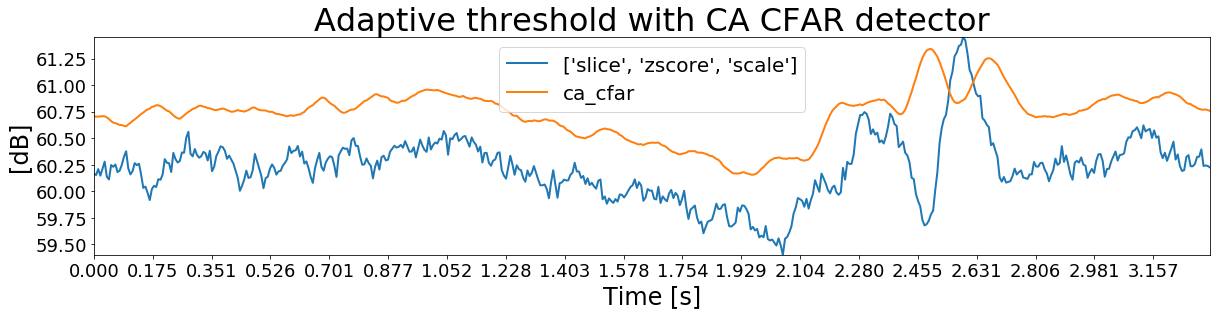

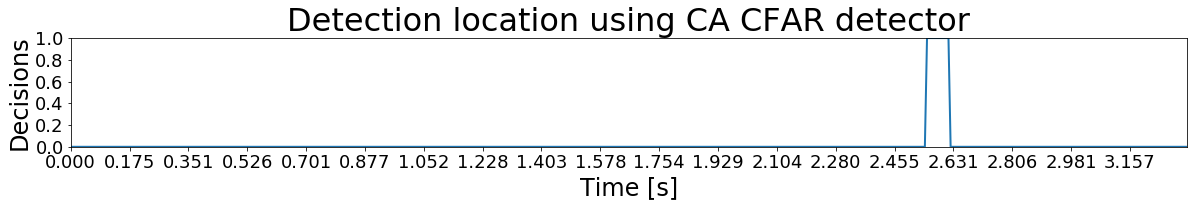

array([['2.590', '61.449']], dtype='<U6')

In [87]:
pfa = theorical_pfa
cfar, cfar_params = 'ca_cfar', [N,G,pfa]
print(cfar,cfar_params)
sample.plot_corr_output([transforms], [transforms_params], [cfar], [cfar_params], kernel=kernel, 
                            thresholds=[], detection=True, figsize=figsize, title='Adaptive threshold with CA CFAR detector',font=font)
sample.plot_detection_pulse(transforms, transforms_params, cfar, cfar_params, kernel=kernel, 
                               figsize=(figsize[0],2), title='Detection location using CA CFAR detector',font=font)
sample.detection_starting_locations(transforms,transforms_params, kernel, cfar, cfar_params)

#### OS CFAR

os_cfar [10, 7, 9, 0.33565379259427286]


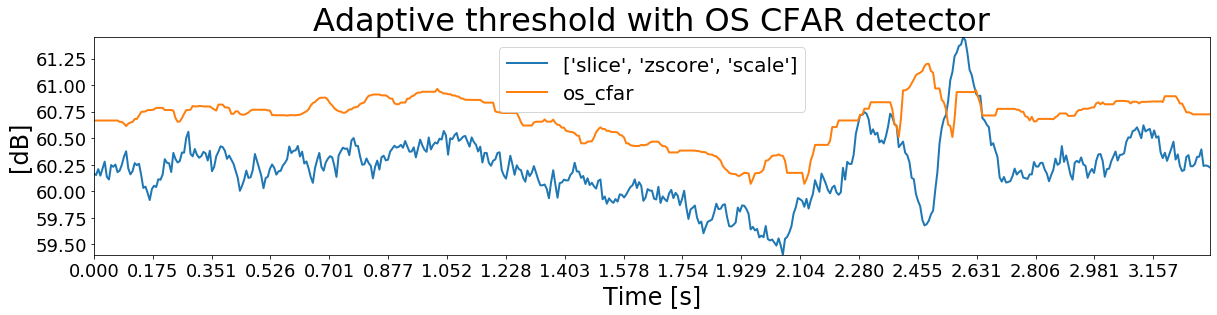

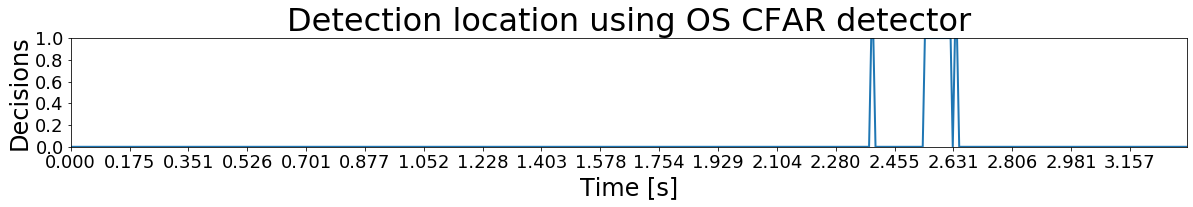

array([['2.386', '60.633'],
       ['2.590', '61.449'],
       ['2.641', '60.900']], dtype='<U6')

In [88]:
k = N-1
cfar, cfar_params = 'os_cfar', [N,G,k,pfa]
print(cfar, cfar_params)
sample.plot_corr_output([transforms], [transforms_params], [cfar], [cfar_params], kernel=kernel, 
                            thresholds=[], detection=True, figsize=figsize, title='Adaptive threshold with OS CFAR detector',font=font)
sample.plot_detection_pulse(transforms, transforms_params, cfar, cfar_params, kernel=kernel, 
                               figsize=(figsize[0],2), title='Detection location using OS CFAR detector',font=font)
sample.detection_starting_locations(transforms,transforms_params, kernel, cfar, cfar_params)

#### TM CFAR

tm_cfar [10, 7, 3, 7, 0.33565379259427286]


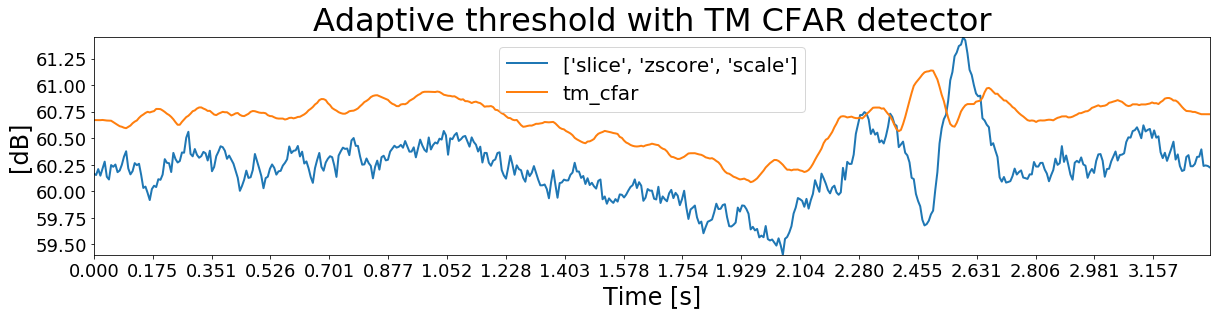

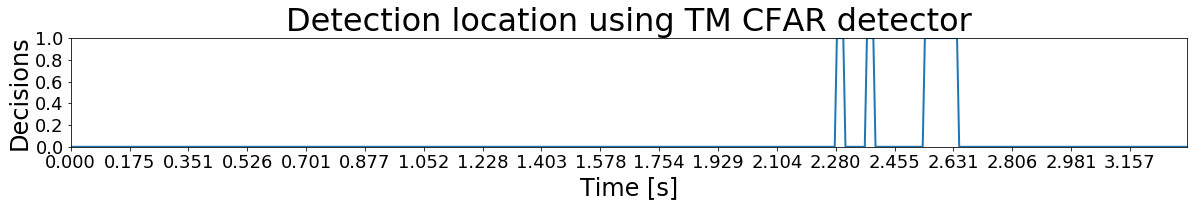

array([['2.296', '60.746'],
       ['2.373', '60.731'],
       ['2.590', '61.449']], dtype='<U6')

In [89]:
T1,T2 = floor(0.3*N), floor(0.7*N)
cfar, cfar_params = 'tm_cfar', [N,G,T1,T2,pfa]
print(cfar, cfar_params)
sample.plot_corr_output([transforms], [transforms_params], [cfar], [cfar_params], kernel=kernel, 
                            thresholds=[], detection=True, figsize=figsize, title='Adaptive threshold with TM CFAR detector',font=font)
sample.plot_detection_pulse(transforms, transforms_params, cfar, cfar_params, kernel=kernel, 
                               figsize=(figsize[0],2), title='Detection location using TM CFAR detector',font=font)
sample.detection_starting_locations(transforms,transforms_params, kernel, cfar, cfar_params)

#### LF CFAR

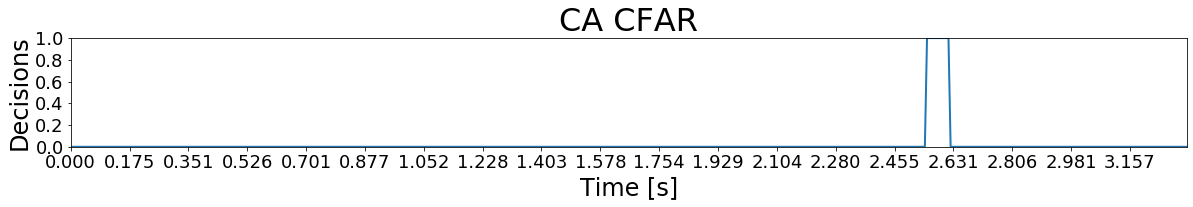

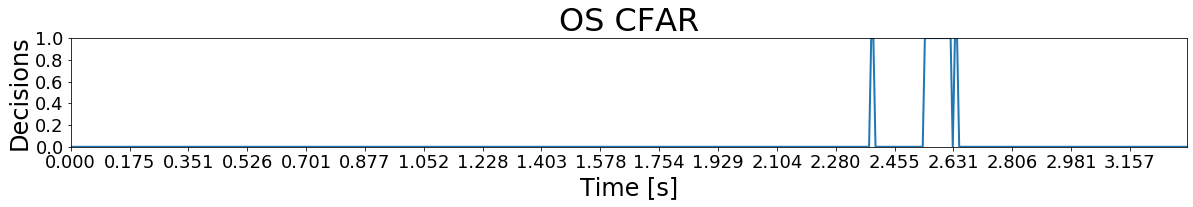

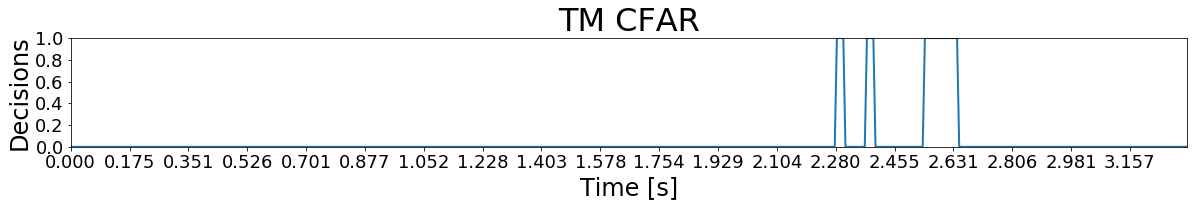

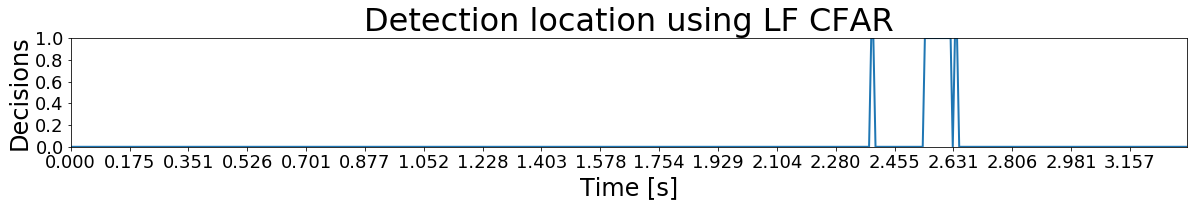

array([['2.386', '60.633'],
       ['2.590', '61.449'],
       ['2.641', '60.900']], dtype='<U6')

In [90]:
detector, detector_params = ['ca_cfar','os_cfar','tm_cfar'],[[N,G,pfa],[N,G,k,pfa],[N,G,T1,T2,pfa]]
sample.plot_detection_pulse(transforms, transforms_params, 'ca_cfar', [N,G,pfa], kernel=kernel, figsize=(figsize[0],2), title='CA CFAR',font=font)
sample.plot_detection_pulse(transforms, transforms_params, 'os_cfar', [N,G,k,pfa], kernel=kernel, figsize=(figsize[0],2), title='OS CFAR',font=font)
sample.plot_detection_pulse(transforms, transforms_params, 'tm_cfar', [N,G,T1,T2,pfa], kernel=kernel, figsize=(figsize[0],2), title='TM CFAR',font=font)
sample.plot_detection_pulse(transforms, transforms_params, 'fusion_cfar', [N,G,k,T1,T2,pfa], kernel=kernel, figsize=(figsize[0],2), title='Detection location using LF CFAR',font=font)
sample.detection_starting_locations(transforms,transforms_params, kernel, 'fusion_cfar', [N,G,k,T1,T2,pfa])

### Detector Output

2013-07-19UT04:14:42.00291922.marion.vr2


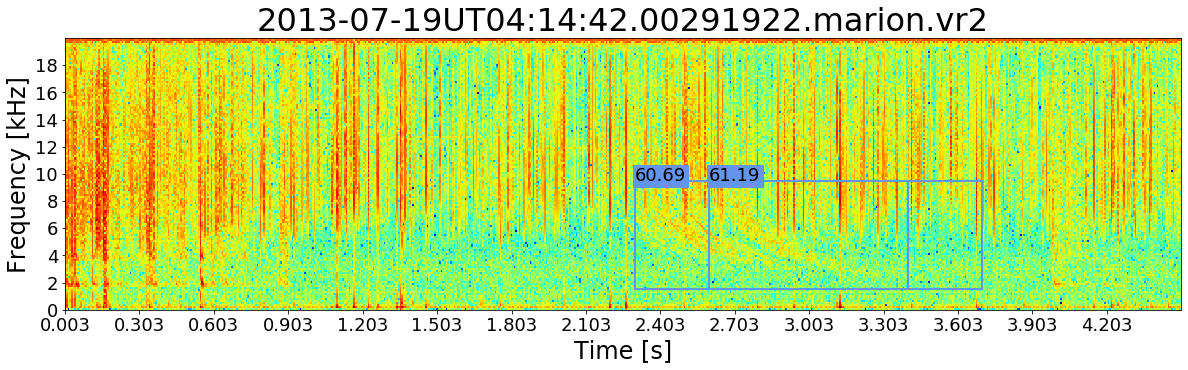

[[60.687  2.3    3.4    1.5    9.5  ]
 [61.194  2.6    3.7    1.5    9.5  ]]


In [2]:
N,G,k,T1,T2,pfa = 10,7,9,3,8,3.36e-01
files = np.random.choice(database.get_train(),3)
# files = ['2013-05-18UT13:49:22.14312156.marion.vr2','2013-07-02UT16:04:50.89891914.marion.vr2',
#          '2013-07-23UT17:43:48.20451906.marion.vr2','2013-04-22UT01:28:03.48279656.marion.vr2','2013-07-26UT03:39:09.21571914.marion.vr2',
#          '2013-07-11UT02:58:27.23171938.marion.vr2','2013-07-19UT04:14:42.00291922.marion.vr2']
files=['2013-07-19UT04:14:42.00291922.marion.vr2']
for file in files:
    print(file)
    sample = CFARDetector(dataset_loc, site, file)
    transforms, transforms_params = ['slice','zscore','scale'], [[1.5,9.5],[None],[0,1]]
    kernel = sample.load_kernel('sim', [0.35,80,1])
    bboxes = sample.detection_bounding_boxes(transforms,transforms_params, kernel, 'fusion_cfar', [N,G,k,T1,T2,pfa], threshold=0, time_error=1, duration=True)
    freq_size = 4
    sample.spectrogram_with_axis(log10=True)
    sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size)
    sample.spectrogram_plot(figsize=(sample.get_figsize()[0],5) , xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                               xaxis=True, yaxis=True,ticks=[0.3,2], title=sample.get_file(), cmap='jet', cmap_show=False, font=font,output=bboxes)
    print(bboxes)


In [ ]:
# cfar
'2013-07-26UT00:41:12.27491914.marion.vr2'
'2013-05-11UT16:14:51.15709664.marion.vr2'
'2013-06-03UT15:55:00.68633094.marion.vr2'
'2013-07-07UT16:04:24.27491914.marion.vr2'
'2013-08-05UT03:49:11.07171914.marion.vr2'
'2013-05-20UT19:32:10.91262156.marion.vr2'
# interesting
'2013-12-16UT03:41:44.89139414.marion.vr2'